<a href="https://colab.research.google.com/github/dkrunal90/NLP-Disaster-Tweets/blob/main/NLP_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem and Data Description


The goal of this project is to analyze a dataset of 10,000 tweets that have been classified as relating to a disaster or non-disaster and create a model that can predict whether a tweet is announcing an actual disaster.  Natural Language Processing has become an important tool in modern disaster detection systems.  Social media can help provide real-time updates during disaster events, making is a very useful resource for news agencies and disaster relief organizations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Input
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import urllib.parse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [5]:
# Load Data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
print(train_data.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


There are some missing values that need to be dealt with but first I am going to clean the text by removing common words, removing punctuation, converting to lowercase, and removing URLs.  This will help ensure the analysis of the text is more targeted for words that would be relevant to determining whether an even is a disaster or not.

In [8]:
# Define stop words
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def clean_text(text):
    # Preprocess text: remove URLs, punctuation, lowercase, and remove stopwords
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords

    return text

# Apply the updated function to the dataset
train_data['text_clean'] = train_data['text'].apply(clean_text)
test_data['text_clean'] = test_data['text'].apply(clean_text)

# Verify the changes
print(train_data[['text_clean']].sample(10, random_state=42))

                                             text_clean
2644          new weapon cause unimaginable destruction
2227  famping things gishwhes got soaked deluge goin...
5448  dt georgegalloway rt gallowaymayor col police ...
132   aftershock back school kick great want thank e...
6845  response trauma children addicts develop defen...
5559  calumsos look like got caught rainstorm amazin...
1765  favorite lady came volunteer meeting hopefully...
1817  brianroemmele ux fail emv people want insert r...
6810      cant find ariana grande shirt fucking tragedy
4398           murderous story americas first hijacking


# Exploratory Data Analysis

First, I want to check the class distribtion to get a sense of how balanced or unbalanced the classes are.  

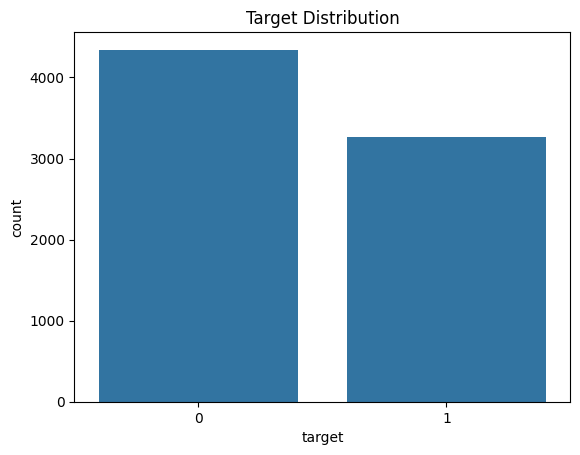

In [9]:
sns.countplot(x='target', data=train_data)
plt.title('Target Distribution')
plt.show()

There doesn't appear to be a huge imbalance in the classes.  Now, I want to look at the top keywords for both classes to see if that data is relevant to the model.  There was missing data for this feature so I want to see if it seems relevant to the analysis before deciding how to handle the missing values.

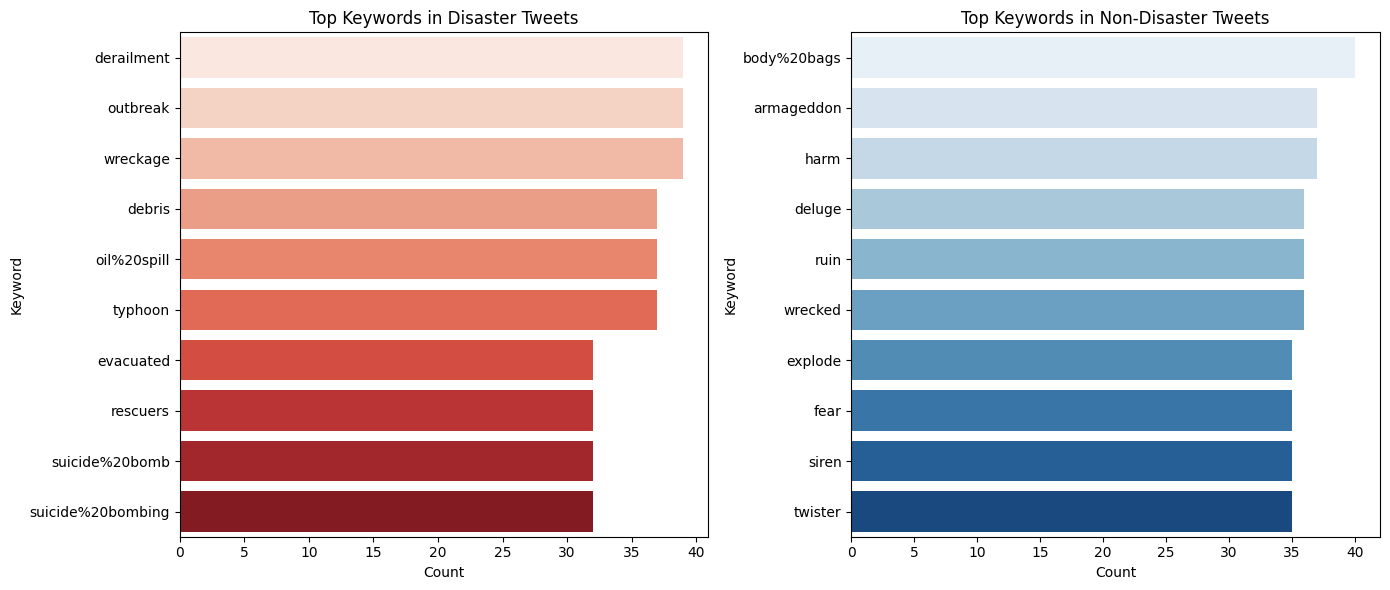

In [10]:
# Group by target and count occurrences of each keyword
disaster_keywords = train_data[train_data['target'] == 1]['keyword'].dropna()
non_disaster_keywords = train_data[train_data['target'] == 0]['keyword'].dropna()

# Get the most common keywords for each class
top_disaster_keywords = Counter(disaster_keywords).most_common(10)
top_non_disaster_keywords = Counter(non_disaster_keywords).most_common(10)

# Convert to DataFrames for easier plotting
disaster_df = pd.DataFrame(top_disaster_keywords, columns=['keyword', 'count'])
non_disaster_df = pd.DataFrame(top_non_disaster_keywords, columns=['keyword', 'count'])

# Plotting
plt.figure(figsize=(14, 6))

# Plot for disaster tweets
plt.subplot(1, 2, 1)
sns.barplot(data=disaster_df, y='keyword', x='count', hue='keyword', palette='Reds', legend=False)
plt.title('Top Keywords in Disaster Tweets')
plt.xlabel('Count')
plt.ylabel('Keyword')

# Plot for non-disaster tweets
plt.subplot(1, 2, 2)
sns.barplot(data=non_disaster_df, y='keyword', x='count', hue='keyword', palette='Blues', legend=False)
plt.title('Top Keywords in Non-Disaster Tweets')
plt.xlabel('Count')
plt.ylabel('Keyword')

plt.tight_layout()
plt.show()

Based on the top keywords, it looks like there isn't a clear distinction between disaster tweets and non-disaster tweets.  A lot of words showing up in non-disaster tweets could lead to misclassification as they would appear to relate to a disaster.  I am going to drop this feature along with location since the location was missing a lot of data and wouldn't provide addtional context for the model.

In [11]:
train_data = train_data.drop(columns=['location', 'keyword'])
train_data['text'] = train_data['text'].astype(str)

I also want to look at the length of the tweets by class to see if there is any major difference between the two.

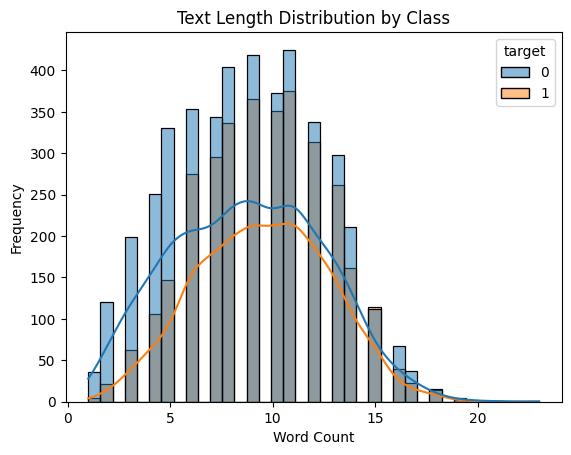

In [12]:
train_data['text_length'] = train_data['text_clean'].apply(lambda x: len(x.split()))
sns.histplot(data=train_data, x='text_length', hue='target', kde=True)
plt.title('Text Length Distribution by Class')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

It doesn't look like there is a huge difference in word count, with tweets classified as a disaster tweet appearing to be somewhat shorter.

# Model Architecture

A SimpleRNN model will be used because it can capture sequential depedencies in tweet text effectively for this problem.  More complex models like LSTM or GRU can handle long-term dependencies better but are more computationally intense, so SimpleRNN provides a good balance of model complexity and efficiency.  RNNs are well-suited for text data, as they can learn sequential patterns, making them ideal for tweet classification. By processing each word in sequence, RNNs can understand context better than non-sequential models.

In [13]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')  # `num_words` limits the vocabulary size
tokenizer.fit_on_texts(train_data['text_clean'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text_clean'])

# Pad sequences to ensure uniform length
max_length = 50  # Adjust based on your data analysis
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')

In [14]:
# Define features and labels
X = train_padded
y = train_data['target']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
print("Shape of train_padded:", train_padded.shape)

Shape of train_padded: (7613, 50)


Now I will use keras tuner to find the best embedding dimensions, rnn units, and dropout rate that will achieve the best f1 score which this project is scored against. I chose embedding dimensions between 16 and 128 to find a balance between capturing word semantics and computational cost. The range for RNN units reflects different capacities for handling complex text patterns, and varying dropout rates are intended to prevent overfitting.

In [16]:
!pip install keras-tuner
import keras_tuner as kt

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

def build_model(hp):
    model = Sequential()

    # Tune the Embedding output dimension
    embedding_dim = hp.Int('embedding_dim', min_value=16, max_value=128, step=16)
    model.add(Embedding(input_dim=10000, output_dim=embedding_dim))

    # Tune the number of RNN units
    rnn_units = hp.Int('rnn_units', min_value=16, max_value=128, step=16)
    model.add(SimpleRNN(units=rnn_units, return_sequences=True))

    # Tune the dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(rate=dropout_rate))

    model.add(SimpleRNN(units=rnn_units))  # Second RNN layer with the same units

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['f1_score'])

    return model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [17]:
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("f1_score", direction="max"),
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='disaster_tweets_rnn'
)

In [18]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32)

Trial 10 Complete [00h 01m 52s]
f1_score: 0.6019283533096313

Best f1_score So Far: 0.6019283533096313
Total elapsed time: 00h 20m 07s


In [19]:
# Get the best hyperparameters and model
best_hp = tuner.get_best_hyperparameters()[0]
best_model = tuner.get_best_models()[0]

# Display the best hyperparameters
print("Best Hyperparameters:")
print(f"Embedding Dimension: {best_hp.get('embedding_dim')}")
print(f"RNN Units: {best_hp.get('rnn_units')}")
print(f"Dropout Rate: {best_hp.get('dropout_rate')}")

# Evaluate the best model
best_model.evaluate(X_val, y_val)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Hyperparameters:
Embedding Dimension: 96
RNN Units: 48
Dropout Rate: 0.5
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - f1_score: 0.6018 - loss: 0.6004


[0.5728737711906433, 0.59760582447052]

Increasing the embedding dimensions improved F1 score up to a point but plateaued around 64 dimensions. Higher dropout rates helped prevent overfitting, while too few RNN units led to lower F1 scores, indicating insufficient model capacity.

In [20]:
from tensorflow.keras import backend as K

# Define the custom F1 Score function with consistent casting
def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(y_pred)
    y_pred = K.cast(y_pred, 'float32')

    tp = K.sum(K.cast(y_true * y_pred, 'float32'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

# Extract best hyperparameters
embedding_dim = best_hp.get('embedding_dim')
rnn_units = best_hp.get('rnn_units')
dropout_rate = best_hp.get('dropout_rate')

# Rebuild the model with the best hyperparameters
model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, input_length=50),
    SimpleRNN(units=rnn_units, return_sequences=True),
    Dropout(rate=dropout_rate),
    SimpleRNN(units=rnn_units),
    Dense(1, activation='sigmoid')
])

# Compile the model with binary cross-entropy and the custom F1 score
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - f1_score: 0.3868 - loss: 0.6889 - val_f1_score: 0.6761 - val_loss: 0.5401
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - f1_score: 0.8128 - loss: 0.3733 - val_f1_score: 0.7006 - val_loss: 0.5722
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - f1_score: 0.9182 - loss: 0.1894 - val_f1_score: 0.7005 - val_loss: 0.6688
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - f1_score: 0.9488 - loss: 0.1250 - val_f1_score: 0.7032 - val_loss: 0.7400
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - f1_score: 0.9564 - loss: 0.0992 - val_f1_score: 0.6934 - val_loss: 0.7804
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - f1_score: 0.9572 - loss: 0.1039 - val_f1_score: 0.6944 - val_loss: 0.7955
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - f1_score: 0.9655 - loss: 0.0827 - val_f1_score: 0.7032 - val_loss: 0.8678
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - f1_score: 0.9722 - loss: 0.0708 - val

# Results and Analysis

In [21]:
# Evaluate the retrained model on the validation set
val_loss, val_f1_score = model.evaluate(X_val, y_val)
print(f"Validation F1 Score: {val_f1_score:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.6786 - loss: 1.0034
Validation F1 Score: 0.6869
Validation Loss: 0.9071


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


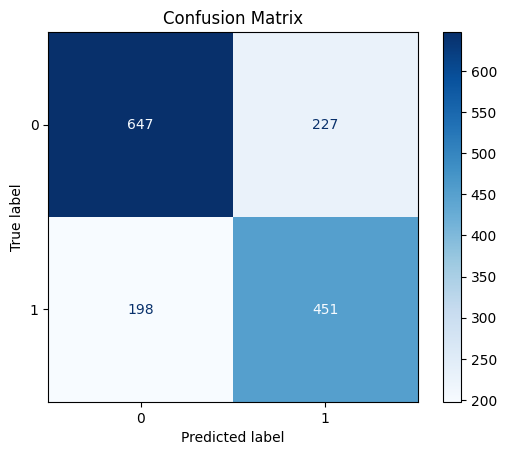

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

val_predictions = (best_model.predict(X_val) > 0.5).astype(int)
cm = confusion_matrix(y_val, val_predictions)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

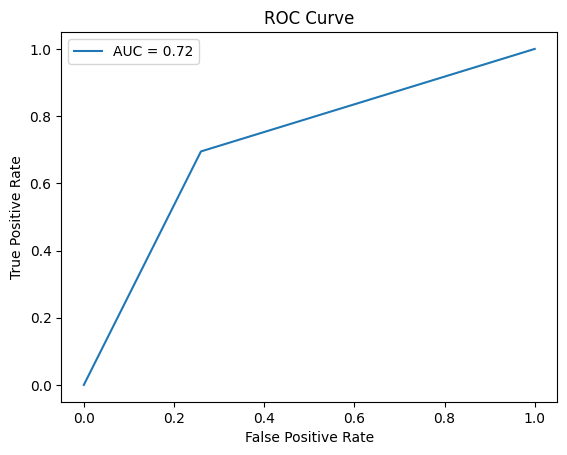

In [23]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_val, val_predictions)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

The AUC of 0.69  shows the model correctly ranks a randomly chosen disaster tweet higher than a non-disaster tweet but the model could use further improvement to improve accuracy.  

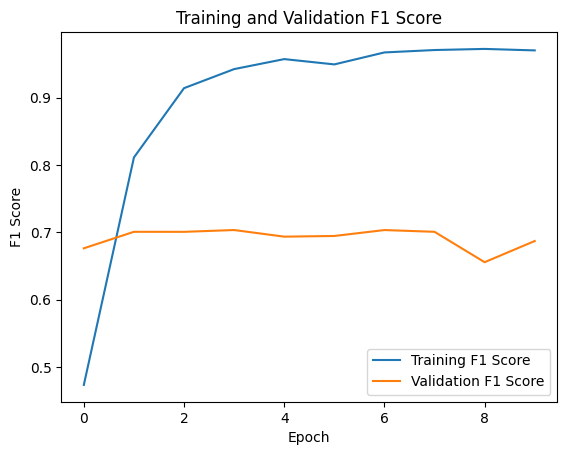

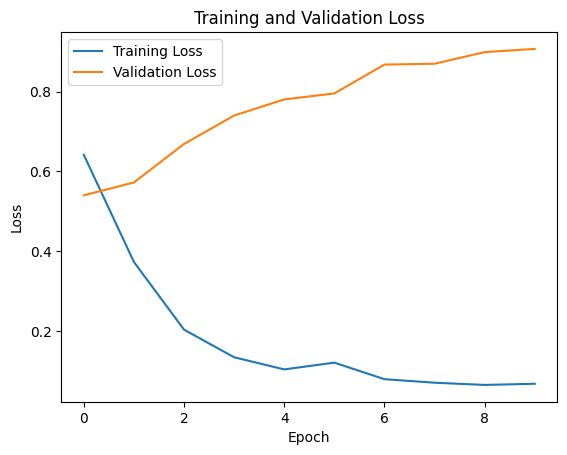

In [24]:
# Plot F1 score
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Training and Validation F1 Score')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

The training and validation loss plots indicate a possible overfitting issue. The training loss continues to decrease steadily across epochs, while the validation loss plateaus or even increases after a few epochs. This divergence suggests that the model is learning specific patterns in the training data that do not generalize well to unseen data, leading to overfitting.  In future iterations I may have to reduce the number of RNN units/layers or limit the embedding layer.

In [25]:
test_data['text_clean'] = test_data['text'].apply(clean_text)

# Preprocess test data
test_sequences = tokenizer.texts_to_sequences(test_data['text_clean'])
test_padded = pad_sequences(test_sequences, maxlen=50, padding='post')

# Make predictions
test_predictions = model.predict(test_padded)
test_predictions = [1 if p > 0.5 else 0 for p in test_predictions]

# Prepare submission file
submission = pd.DataFrame({'id': test_data['id'], 'target': test_predictions})
submission.to_csv('submission.csv', index=False)
from google.colab import files
files.download('submission.csv')

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusions

The analysis suggests that an RNN model can improve disaster classification by capturing sequential word patterns. The score in my submitted model to Kaggle was 0.677 and shows room for improvement.  The model showed signs of overfitting, and further improvements could be achieved with pre-trained embeddings and more complex architectures like LSTM. In the future I might try experimenting with pre-trained embeddings, bi-directional RNNs, and exploring NLP-specific data augmentation techniques to see how they would improve the model.